# Retraining the 3D Unet

In this training the following improvements are implemented
- Speed up data augumentation for better utilization of the GPU (especially if elastic deformations are enabled)
- Use soft dice loss which hopefully improves the boundaries of the segmentation mask
- Use the new Dataset3D class to take in data which should improve documentation and comparability of the training process.

Once a reference dataset is established, hyperparameter tuning will be investigated.



In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time
import h5py
from tqdm import tqdm
from importlib import reload
import itertools

import tensorflow as tf

In [2]:
# Import modules providing tools for image manipulation
import sys
sys.path.append('../../tools')
import tilingStrategy, Dataset3D, visualization
sys.path.append('..')
import utilities, model
reload(utilities)
reload(Dataset3D) 

<module 'Dataset3D' from '../../tools\\Dataset3D.py'>

In [3]:
# Fix for tensorflow-gpu issues that I found online... (don't ask me what it does)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Data Input Pipeline

The dataset is prepared in the form of a h5 file. The Dataset class provided by the Dataset3D module can be used for easy access to the training data.


In [4]:
# Load images and masks from a previously created dataset
#base_dir = 'C:\\Users\\lillvisj\\linus\\'
base_dir = 'C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\'
dataset_path = base_dir+'test_dataset.h5'
dataset = Dataset3D.Dataset(dataset_path) # The Dataset3D class handles all file level i/o operations

print('Dataset {} contains {} records'.format(dataset, len(dataset)))

Opened dataset with 47 preexisting items. Overwriting items with the same name.
Dataset <Dataset3D.Dataset object at 0x000001B7AE55C1C8> contains 47 records


In [5]:
# get a list of all records in the database
entries = list(dataset.keys())

# Make a train test split and retrieve a callable -> that produces a generator -> that yields the recods specified by the key list in random order
training = dataset.getGenerator(entries[:30])
test = dataset.getGenerator(entries[:30])

# gen = training() # calling the callable training produces a generator
# next(gen) -> (image, mask) yields the records identified by the key list

In [14]:
# Instantiate tf Datasets from the generator producing callables, specify the datatype and shape of the generator output
trainingset_raw = tf.data.Dataset.from_generator(training, 
    output_types=(tf.float32, tf.int32),
    output_shapes=(tf.TensorShape([220,220,220]),tf.TensorShape([132,132,132])))
testset_raw = tf.data.Dataset.from_generator(test, 
    output_types=(tf.float32, tf.int32),
    output_shapes=(tf.TensorShape([220,220,220]),tf.TensorShape([132,132,132])))

# The unet expects the input data to have an additional channel axis. We can add this during preprocessing
def addChannel(x,y):
    return tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1)

# each entry is preprocessed by passing it through this function
def preprocess(x,y):
    # clip, and z normalize image
    x = tf.clip_by_value(x, 0, 1400)
    x = tf.subtract(x, 140)
    x = tf.divide(x, 40)
    # binarize mask
    y = tf.clip_by_value(y,0,1)
    return x, y
    
# chain dataset transformations to construct the input pipeline for training
# 1. preprocess the raw data by clipping and normalizing the image. The mask is binarized
# 2. A new axis is added to the tensors -> (x,y,z,c) format
# 3. elastic transformations are applied to both tensors. This mapping operation is parallelized to increase throughput as this is the most time consuming step in preprocessing. The number of parallel calls is automatically tuned for performance. 
# 4. random affine transformations are applied
# 5. entries are batched -> (b,x,y,z,c) format
# 6. Some training examples are prefetched which decouples preprocessing from model execution. The number of prefetched samples is tuned automatically for performance. 
trainingset = trainingset_raw.map(preprocess).map(addChannel).map(utilities.tf_elastic, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(utilities.tf_affine).batch(1).prefetch(tf.data.experimental.AUTOTUNE)

# chain dataset transformations to construct the input pipeline for testing
# 1. preprocess the raw data by clipping and normalizing the image. The mask is binarized
# 2. A new axis is added to the tensors -> (x,y,z,c) format
# 3. random affine transformations are applied
# 5. entries are batched -> (b,x,y,z,c) format
# 6. Some training examples are prefetched which decouples preprocessing from model execution. The number of prefetched samples is tuned automatically for performance. 
testset = testset_raw.map(preprocess).map(addChannel).map(utilities.tf_affine).batch(1).prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
# Visualize an example from the dataset
# build the input pipeline minus parallelization and prefetching -> executed on demand only
inspectset = trainingset_raw.map(preprocess).map(addChannel).map(utilities.tf_elastic).map(utilities.tf_affine).batch(1)
inspectset_iterator = iter(inspectset)

got image with shape (1, 220, 220, 220, 1)\got mask with shape (1, 132, 132, 132, 1)


got image with shape (1, 220, 220, 220, 1)
got mask with shape (1, 132, 132, 132, 1)


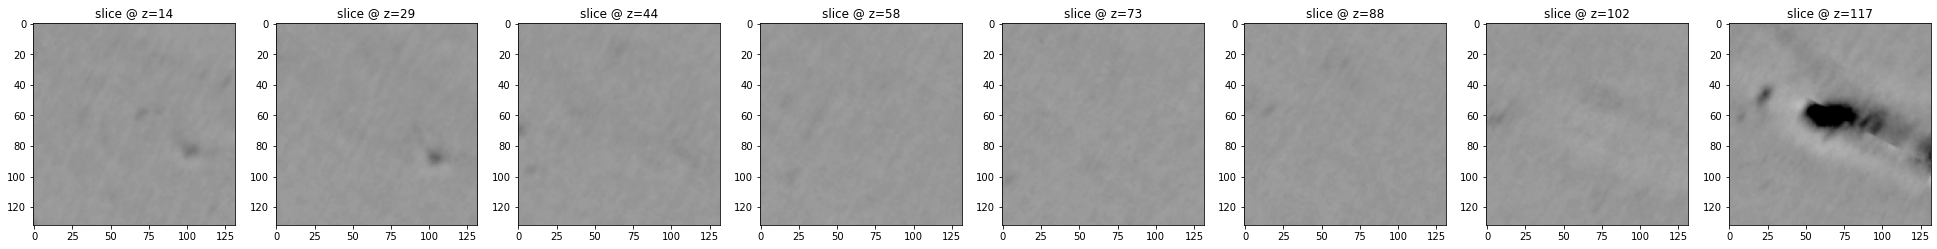

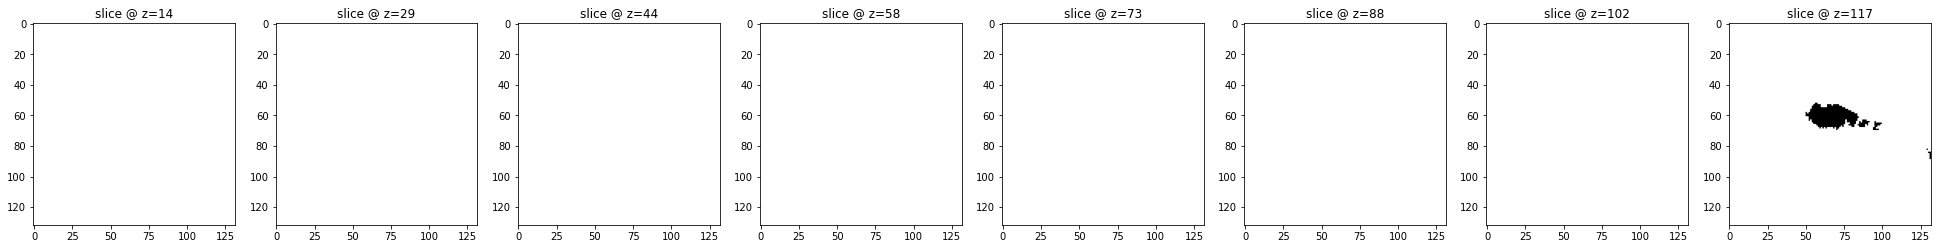

In [28]:
image, mask = next(inspectset_iterator)
print('got image with shape {}\ngot mask with shape {}'.format(image.numpy().shape,mask.numpy().shape))
visualization.showZSlices(image.numpy()[0,44:176,44:176,44:176,:], mode='gray', n_slices=8, vmin=-4, vmax=4)
visualization.showZSlices(mask.numpy()[0,...], mode='gray', n_slices=8, vmin=0, vmax=1)

## Training the Unet

In [20]:
reload(model)

<module 'model' from '..\\model.py'>

In [8]:
# Define the model (build is triggered on first call)
unet = model.build_unet(input_shape=(220,220,220,1), n_blocks=2, initial_filters=4)


In [9]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 22 0                                            
__________________________________________________________________________________________________
input_block (InputBlock)        ((None, 108, 108, 10 984         input_1[0][0]                    
__________________________________________________________________________________________________
downsample_block (DownsampleBlo ((None, 52, 52, 52,  5208        input_block[0][0]                
__________________________________________________________________________________________________
downsample_block_1 (DownsampleB ((None, 24, 24, 24,  20784       downsample_block[0][0]           
______________________________________________________________________________________________

In [10]:
unet.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = model.weighted_sparse_categorical_crossentropy(class_weights=[1,40])
             )

In [11]:
start = time.time()
history = unet.fit(trainingset, epochs=5,
                   validation_data= testset,
                   #callbacks=[tf.keras.callbacks.ModelCheckpoint('test.h5', save_best_only=True)],
                   )
end = time.time()
print('training took {} s'.format(end-start))

Epoch 1/5
30/30 [==============================] - 205s 7s/step - loss: 0.4123 - val_loss: 0.3663
Epoch 2/5
30/30 [==============================] - 211s 7s/step - loss: 0.3486 - val_loss: 0.2615
Epoch 3/5
30/30 [==============================] - 200s 7s/step - loss: 0.2584 - val_loss: 0.1772
Epoch 4/5
30/30 [==============================] - 202s 7s/step - loss: 0.1174 - val_loss: 0.0877
Epoch 5/5
30/30 [==============================] - 201s 7s/step - loss: 0.1047 - val_loss: 0.1038
training took 1019.3101406097412 s


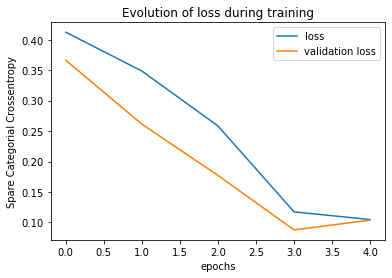

In [29]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','validation loss'])
plt.title('Evolution of loss during training')
plt.xlabel('epochs')
plt.ylabel('Spare Categorial Crossentropy')
plt.savefig('3d_unet_test.png')

In [7]:
model_path = 'C:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\retrain0727\\3d_unet_0728.h5'
# Restore the trained model. Specify where keras can find custom objects that were used to build the unet
unet = tf.keras.models.load_model(model_path, compile=False,
                                  custom_objects={"InputBlock" : model.InputBlock,
                                                    "DownsampleBlock" : model.DownsampleBlock,
                                                    "BottleneckBlock" : model.BottleneckBlock,
                                                    "UpsampleBlock" : model.UpsampleBlock,
                                                    "OutputBlock" : model.OutputBlock})

In [32]:
# Instantiate an iterator over the test set to get sample predictions while retaining the input data
testset_iter = iter(testset)
test_batch = next(testset_iter)

(1, 132, 132, 132, 2)


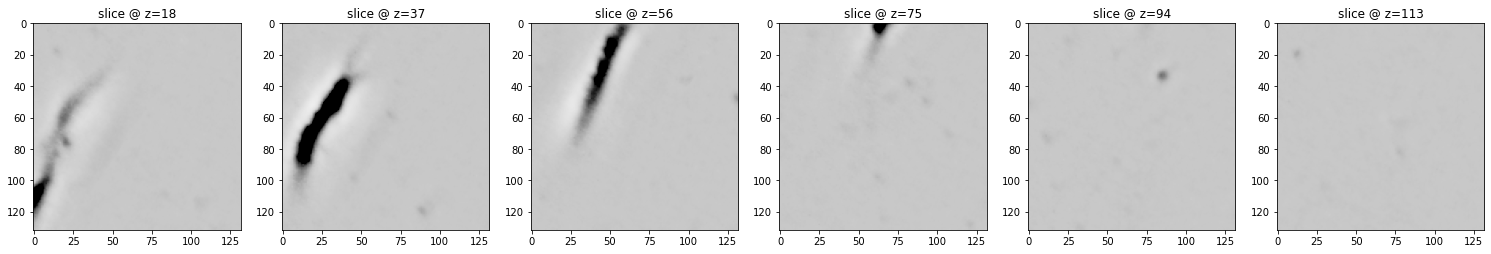

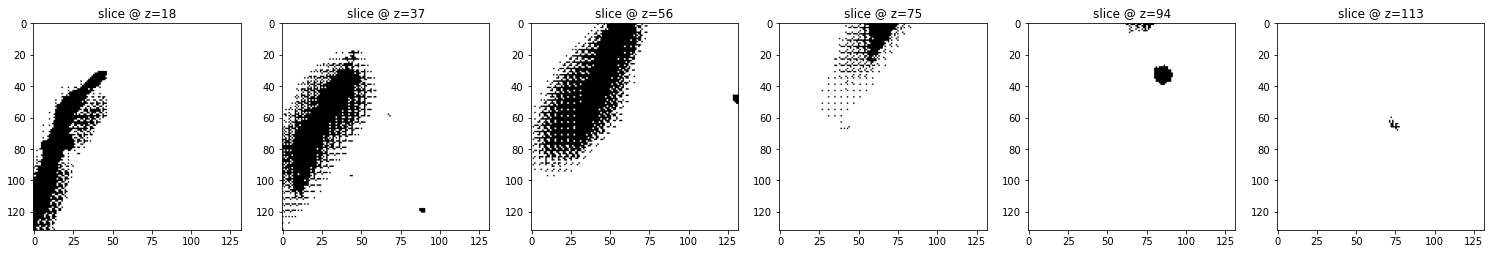

In [33]:
# get sample predictions on the test data
sample_prediction = unet.predict(test_batch)
print(sample_prediction.shape)
sample_prediction_mask = utilities.segmentationMask(sample_prediction)
visualization.showZSlices(test_batch[0][0,44:176,44:176,44:176,:], mode='gray', vmin=-5, vmax=10, n_slices=6)
visualization.showZSlices(sample_prediction_mask[0], mode='gray', vmin=0, vmax=1, n_slices=6)

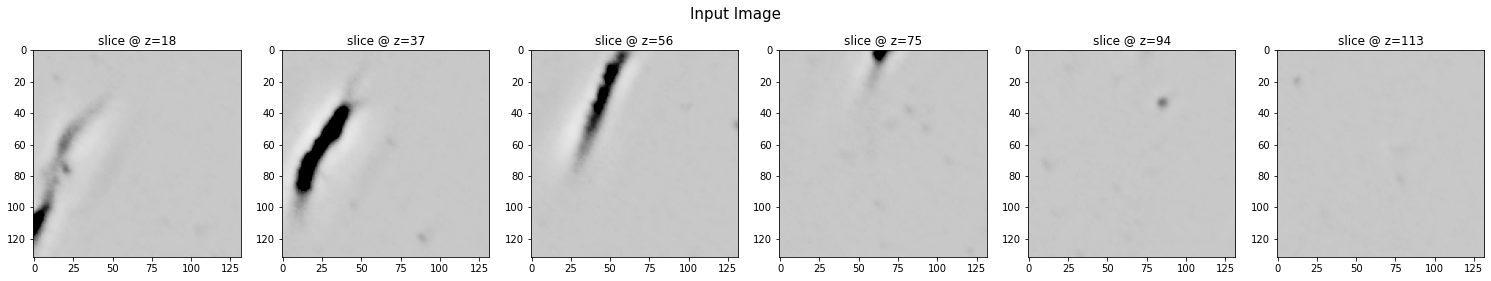

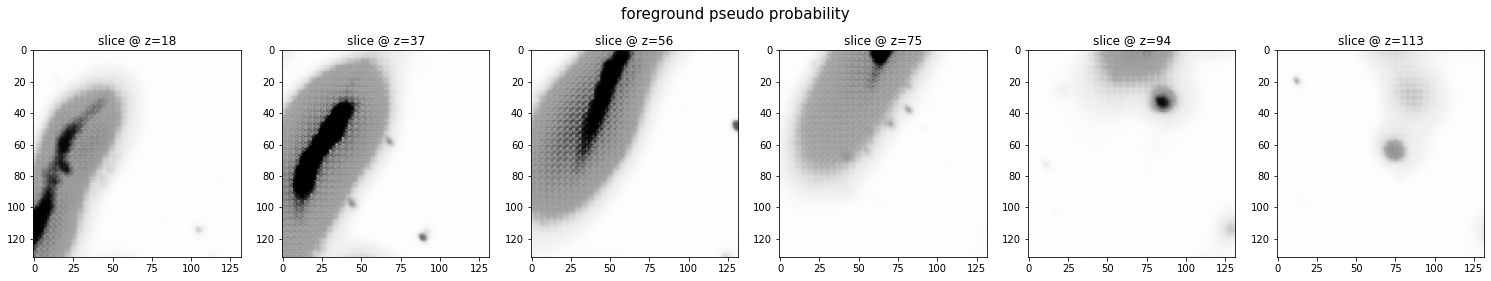

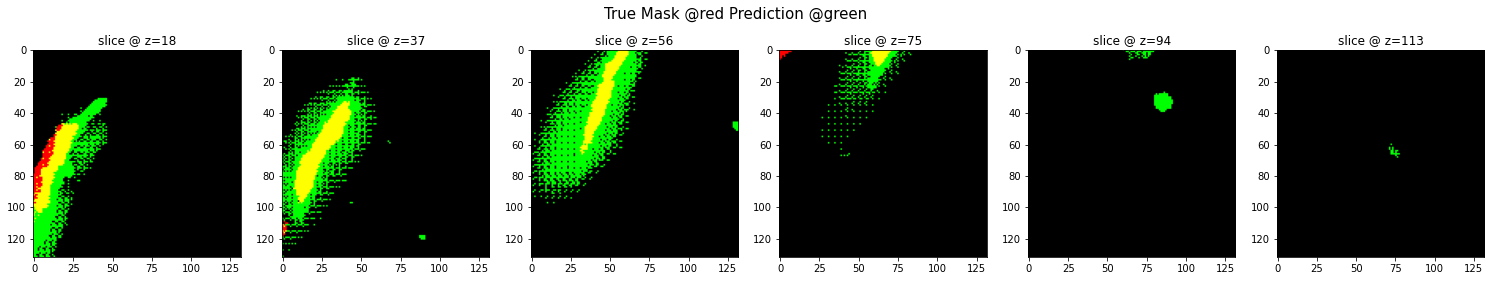

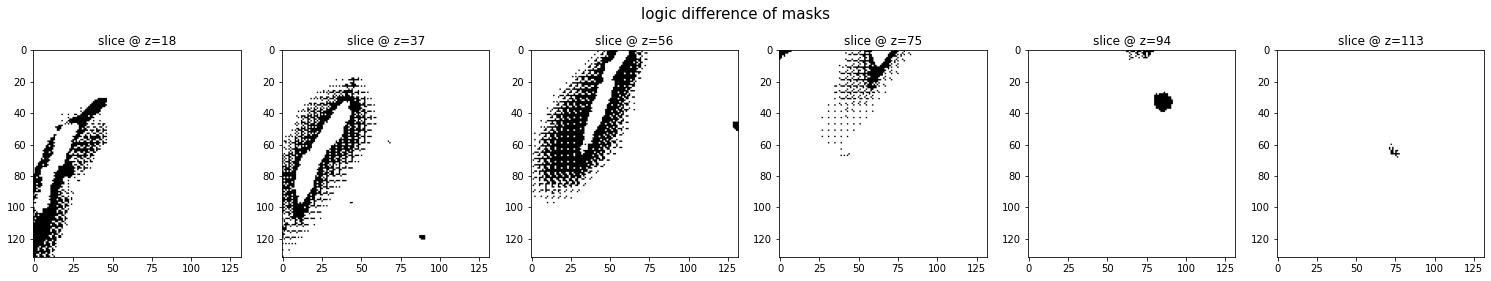

In [34]:
# Prediction evaluation cockpit 
visualization.showZSlices(test_batch[0][0,44:176,44:176,44:176,:], channel=0, n_slices=6, title='Input Image',vmin=-5, vmax=10)
prob = utilities.applySoftmax(sample_prediction)
visualization.showZSlices(prob[0], channel=1,n_slices=6, title='foreground pseudo probability', vmin=0, vmax=1)
mask_overlay = visualization.makeRGBComposite(r=test_batch[1], g=sample_prediction_mask,b=None, gain=255) # Make an overlay of the true mask (red) and the predicted mask (green)
visualization.showZSlices(mask_overlay[0],n_slices=6, mode='rgb', title='True Mask @red Prediction @green')
logic_diff = sample_prediction_mask !=  test_batch[1]
visualization.showZSlices(logic_diff[0], channel=0, n_slices=6, title='logic difference of masks')

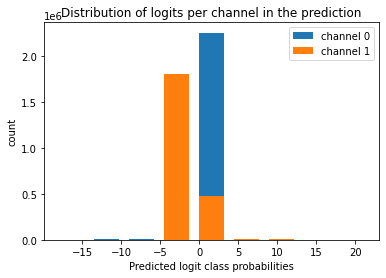

In [36]:
visualization.showLogitDistribution(sample_prediction)